# Homework 3 : The project

Choice of the study : Fake News - dataset based on FakeNewsNet -
https://www.kaggle.com/datasets/algord/fake-news

Importing the studied dataset and displaying the first lines to get a quick overview of the data.

In [148]:
import pandas as pd
file_path = 'FakeNewsNet.csv'
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


Point of the study: 
How can we detect fakenews ?

0) Cleaning dataset so we don't get the urls
1) Proportion of fake vs real
2) Are fake news more shared than real ones ?
3) Can we judge if news are fake depending on the website ?
4) Are some websites more shared than others ? (Would also mean they might be more followed on twitter)
5) Which words are the more present in the titles ? Deduce topics (Excluding any stopword) 
6) Are some topics more shared than others ?
7) Are some topics more likely to be fake ?
8) Are titles containing insults more likely to get shared ?
9) Are titles containing ... more likely to get shared ? (I'm thinking about the too enthusiastic titles but maybe other words will come up in the study)

### 0) Cleaning dataset so we don't get the urls

In [149]:
df_no_url = df.drop(columns=['news_url']).copy()
display(df_no_url.head(5))

,title,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,www.zerchoo.com,38,1


### 1) Proportion of fake vs real
75% of fake vs 25% of real

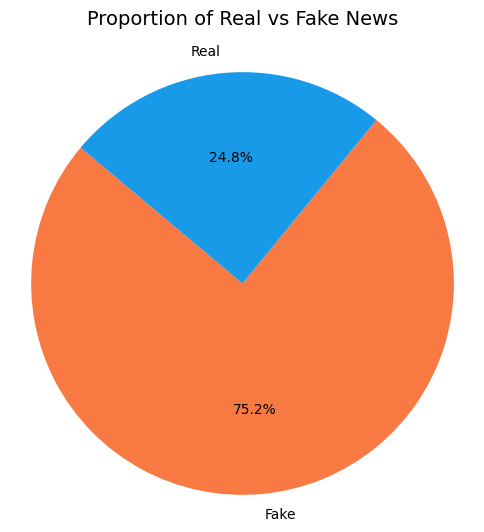

In [150]:
import matplotlib.pyplot as plt
# Count the occurrences of each value in the 'real' column
real_counts = df['real'].value_counts()

# Plotting
plt.figure(figsize=(6, 6))
plt.pie(real_counts, labels=['Fake', 'Real'],colors=['#F97942','#199AE9'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Real vs Fake News', pad=20, fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### 2) Are fake news more shared than real ones ?
No, real news are almost twice as shared as fake ones
And even though there are three times more fake 
So if we multiply by the proportion of fake or real news => Real news are shared 6 times more than fakes ones. 

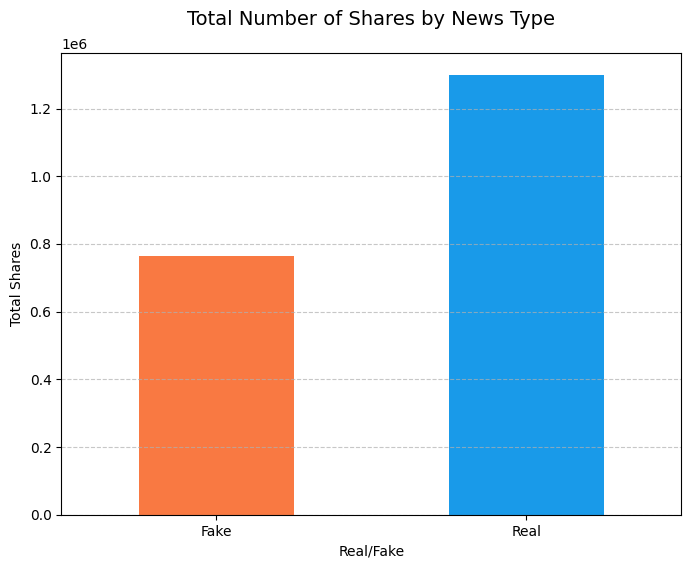

In [151]:
# Grouping by 'real' column and summing the 'shares' column
shares_by_real = df.groupby('real')['tweet_num'].sum()

# Plotting
plt.figure(figsize=(8, 6))
shares_by_real.plot(kind='bar', color=['#F97942','#199AE9'])
plt.title('Total Number of Shares by News Type', pad=20, fontsize=14)
plt.xlabel('Real/Fake')
plt.ylabel('Total Shares')
plt.xticks([0, 1], ['Fake', 'Real'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 3) Can we judge if news are fake depending on the website ?
Apparently yes, as seen on the stacked bar plot. The pie chart shows of many sources are trusworthy. And the word clouds show directly which sources to trust or not.

/!\ At first when looking at sources publishing the most, it seems like there aren't a lot of sources 100% real. But, the pie chart shows it isn't true. So we can conclude that sources 100% real just publish less.

In [152]:
# Count the number of unique values in the source_domain column
num_unique_domains = df['source_domain'].nunique()

print("Number of different source domains:", num_unique_domains)


Number of different source domains: 2441


<Figure size 1800x1000 with 0 Axes>

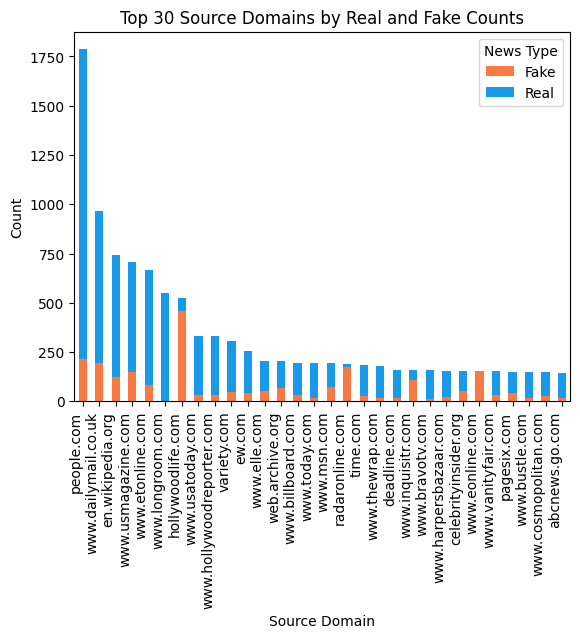

In [153]:
# Group by domain and 'real' status, count occurrences
domain_real_counts = df.groupby(['source_domain', 'real']).size().unstack(fill_value=0)

top_n = 30  # Choose the top N domains to display
domains_to_plot = domain_real_counts.sum(axis=1).nlargest(top_n).index
domain_real_counts = domain_real_counts.reindex(domains_to_plot)

plt.figure(figsize=(18, 10))
domain_real_counts.plot(kind='bar', stacked=True, color=['#F97942', '#199AE9'])  # Orange for 'Fake', Blue for 'Real'
plt.title(f'Top {top_n} Source Domains by Real and Fake Counts')
plt.xlabel('Source Domain')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.legend(['Fake', 'Real'], title="News Type")
plt.show()


In [154]:
# Group by 'source_domain' and count occurrences of each 'real' status
grouped = df.groupby('source_domain')['real'].value_counts().unstack(fill_value=0)

# Calculate percentage of real and fake news for each source_domain
grouped['total'] = grouped.sum(axis=1)
grouped['percent_real'] = grouped[1] / grouped['total']
grouped['percent_fake'] = grouped[0] / grouped['total']

# Filter the top 20 source domains based on the total number of news articles
top_20_domains = grouped['total'].nlargest(20).index

# Filter domains with more than 90% real news and more than 50% fake news among the top 20 domains
# real_news_90 = grouped[grouped.index.isin(top_20_domains) & (grouped['percent_real'] == 1)].index.tolist()
# fake_news_50 = grouped[grouped.index.isin(top_20_domains) & (grouped['percent_fake'] > 0.5)].index.tolist()

real_news_90 = grouped[grouped['percent_real'] == 1].index.tolist()
fake_news_50 = grouped[grouped['percent_fake'] > 0.5].index.tolist()

count_real_news_90 = len(real_news_90)
count_fake_news_50 = len(fake_news_50)

print("Source domains with more than 90% real news among the top 20 domains:")
print(real_news_90)
print("\nSource domains with more than 50% fake news among the top 20 domains:")
print(fake_news_50)

print("\nNumber of domains with more than 90% real news:", count_real_news_90)
print("Number of domains with more than 50% fake news:", count_fake_news_50)

Source domains with more than 90% real news among the top 20 domains:
['1001.com.do', '101kgb.iheart.com', '1029now.iheart.com', '1043myfm.iheart.com', '1061kissfm.iheart.com', '1iota.com', '234today.com', '2loudmag.com', '35.196.40.165', '6abc.com', '7thheaven.wikia.com', '925xtu.com', '939litefm.iheart.com', '949thebull.iheart.com', '953jamz.com', '957thespot.radio.com', '975online.iheart.com', '99tune.us', 'abc13.com', 'abc7news.com', 'abc7ny.com', 'about.hm.com', 'about.usps.com', 'acriticalreviewofthehelp.wordpress.com', 'action.citizen.org', 'adelove.com', 'admin.xnug.uk', 'ag.ny.gov', 'agt.fandom.com', 'alexander.senate.gov', 'alice955.iheart.com', 'allaboutthetea.com', 'allblackmedia.com', 'allthingslawandorder.blogspot.com', 'allthingsrh.com', 'amazingrace.wikia.com', 'america.aljazeera.com', 'americaneedsmitt.com', 'americanidol.wikia.com', 'americaspeaksink.com', 'aminoapps.com', 'amnayzh.wordpress.com', 'amplifiedpost.com', 'amysmartgirls.com', 'archive.li', 'archive.org', 

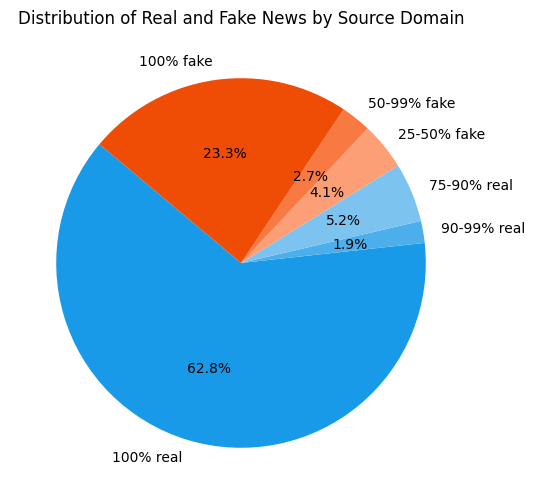

In [155]:
# Group by 'source_domain' and count occurrences of each 'real' status
grouped = df.groupby('source_domain')['real'].value_counts().unstack(fill_value=0)

# Calculate percentage of real and fake news for each source_domain
grouped['total'] = grouped.sum(axis=1)
grouped['percent_real'] = grouped[1] / grouped['total']
grouped['percent_fake'] = grouped[0] / grouped['total']

# Classify source domains based on percentage of real and fake news
real_news_100 = grouped[grouped['percent_real'] == 1].index.tolist()
real_news_90 = grouped[(grouped['percent_real'] > 0.9) & (grouped['percent_real'] < 1)].index.tolist()
real_news_75 = grouped[(grouped['percent_real'] > 0.75) & (grouped['percent_real'] < 0.9)].index.tolist()
real_news_50 = grouped[(grouped['percent_real'] > 0.5) & (grouped['percent_real'] < 0.75)].index.tolist()
real_news_0 = grouped[(grouped['percent_real'] < 0.5) & (grouped['percent_fake'] < 1)].index.tolist()
fake_news_100 = grouped[(grouped['percent_fake'] ==1)].index.tolist()



# Count the number of domains falling into each category
count_real_news_100 = len(real_news_100)
count_real_news_90 = len(real_news_90)
count_real_news_75 = len(real_news_75)
count_real_news_50 = len(real_news_50)
count_real_news_0 = len(real_news_0)
count_fake_news_100 = len(fake_news_100)

# Plotting
plt.figure(figsize=(6, 6))

# Pie chart
labels = ['100% real','90-99% real','75-90% real', '25-50% fake', '50-99% fake', '100% fake']
sizes = [count_real_news_100, count_real_news_90, count_real_news_75, count_real_news_50, count_real_news_0, count_fake_news_100]
colors = ['#199AE9','#4CAFEB', '#7CC3EF', '#FC9F77', '#F97942', '#EF4C06']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Real and Fake News by Source Domain')

plt.show()


In [156]:
!pip install wordcloud

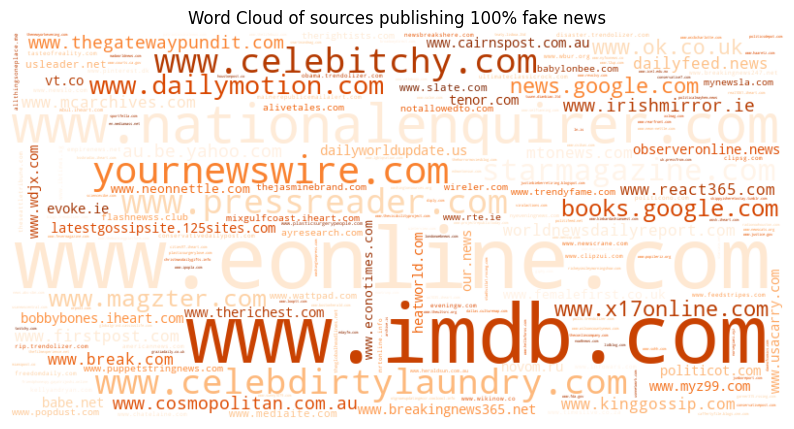

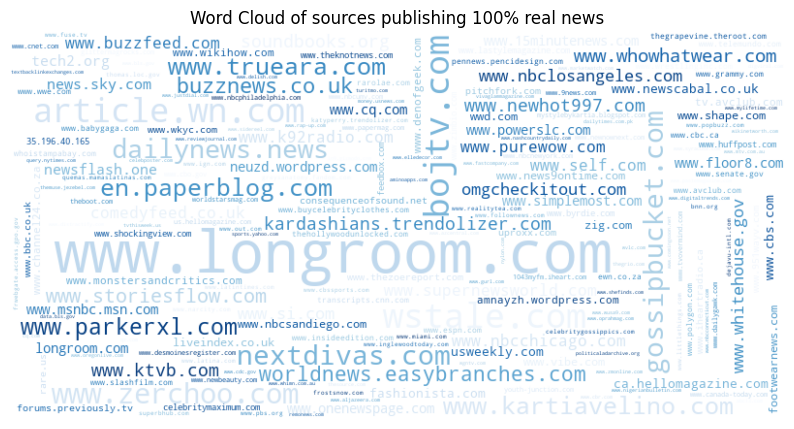

In [157]:
from wordcloud import WordCloud
def create_word(list,color,title):
    sources_df = df[df['source_domain'].isin(list)]
    # Generate a word cloud based on the frequency of source domains
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap=color).generate_from_frequencies(sources_df['source_domain'].value_counts())
    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

create_word(fake_news_100,'Oranges','Word Cloud of sources publishing 100% fake news')
create_word(real_news_100,'Blues','Word Cloud of sources publishing 100% real news')


### 4) Are some websites more shared than others ? (Would also mean they might be more followed on twitter)

                              count    sum  average_retweets
source_domain                                               
www.house.gov                     1  29060           29060.0
us3.campaign-archive1.com         1  21182           21182.0
beta.criticalmention.com          1  10164           10164.0
www.pollingreport.com             1   8883            8883.0
usnnetwork.com                    1   6304            6304.0
...                             ...    ...               ...
www.warnermusicnashville.com      1      0               0.0
www.fdic.gov                      1      0               0.0
politics.blogs.foxnews.com        1      0               0.0
energycommerce.house.gov          1      0               0.0
www.opreminfo.com                 1      0               0.0

[2441 rows x 3 columns]


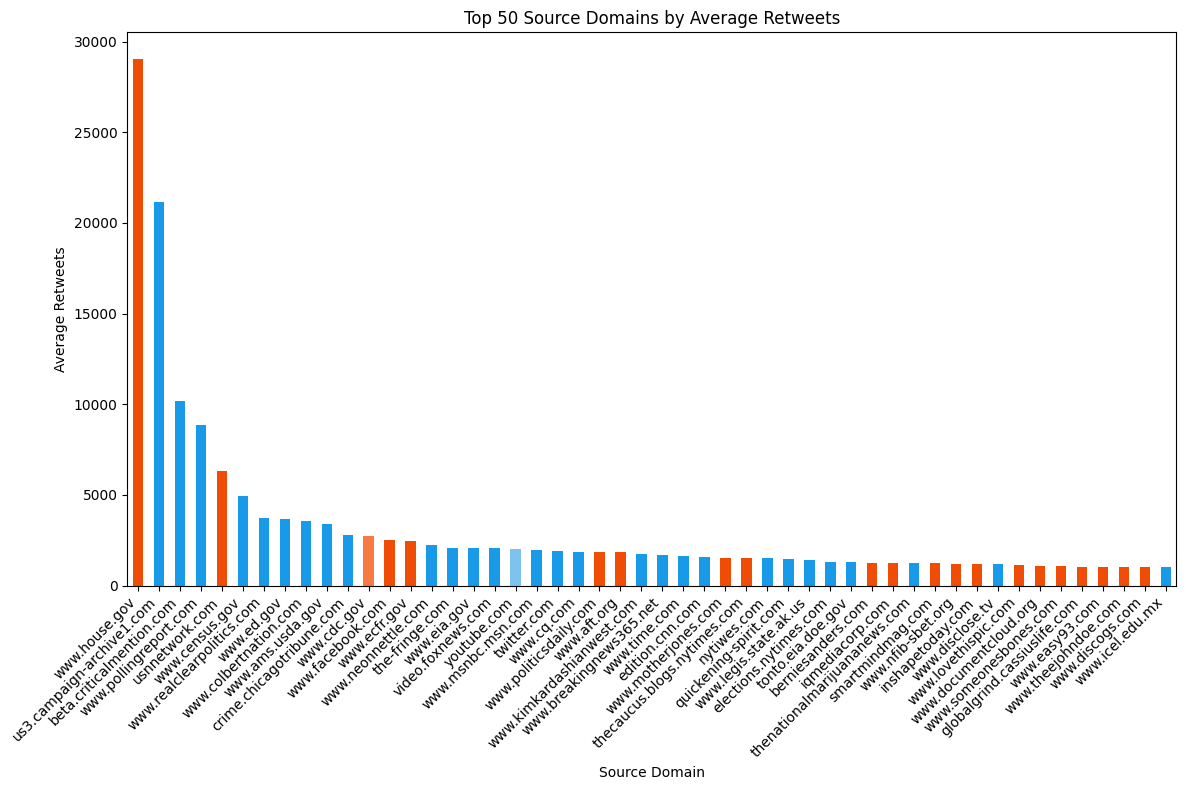

In [158]:
source_domain_data = df.groupby('source_domain')['tweet_num'].agg(['count', 'sum'])

# Calculate average retweets
source_domain_data['average_retweets'] = source_domain_data['sum'] / source_domain_data['count']

# Sort the domains by average retweets
sorted_domains = source_domain_data.sort_values(by='average_retweets', ascending=False)

print(sorted_domains)
top_50_domains = sorted_domains.head(50)

# Plotting the bar chart with color-coded bars based on classification
plt.figure(figsize=(12, 8))
colors = []

for domain in top_50_domains.index:
    if domain in real_news_100:
        colors.append('#199AE9')
    elif domain in real_news_90:
        colors.append('#4CAFEB')
    elif domain in real_news_75:
        colors.append('#7CC3EF')
    elif domain in real_news_50:
        colors.append('#FC9F77')
    elif domain in real_news_0:
        colors.append('#F97942')
    elif domain in fake_news_100:
        colors.append('#EF4C06')

top_50_domains['average_retweets'].plot(kind='bar', color=colors)
plt.title('Top 50 Source Domains by Average Retweets')
plt.xlabel('Source Domain')
plt.ylabel('Average Retweets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

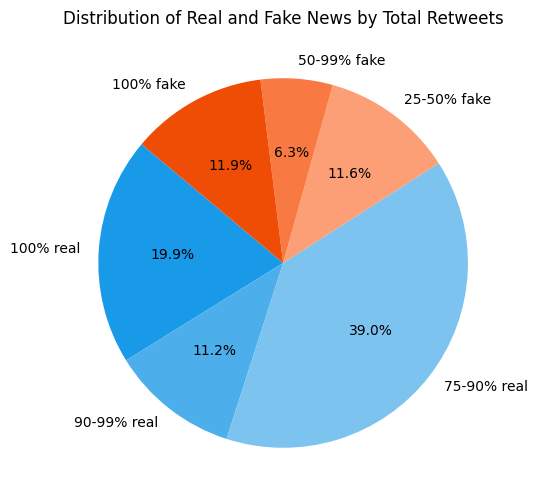

In [159]:
# Calculate the total number of shares (tweet_num) per category
total_shares_real_news_100 = df[df['source_domain'].isin(real_news_100)]['tweet_num'].sum()
total_shares_real_news_90 = df[df['source_domain'].isin(real_news_90)]['tweet_num'].sum()
total_shares_real_news_75 = df[df['source_domain'].isin(real_news_75)]['tweet_num'].sum()
total_shares_real_news_50 = df[df['source_domain'].isin(real_news_50)]['tweet_num'].sum()
total_shares_real_news_0 = df[df['source_domain'].isin(real_news_0)]['tweet_num'].sum()
total_shares_fake_news_100 = df[df['source_domain'].isin(fake_news_100)]['tweet_num'].sum()

# Plotting
plt.figure(figsize=(6, 6))

# Pie chart
labels = ['100% real','90-99% real','75-90% real', '25-50% fake', '50-99% fake', '100% fake']
sizes = [total_shares_real_news_100, total_shares_real_news_90, total_shares_real_news_75,
         total_shares_real_news_50, total_shares_real_news_0, total_shares_fake_news_100]
colors = ['#199AE9','#4CAFEB', '#7CC3EF', '#FC9F77', '#F97942', '#EF4C06']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Real and Fake News by Total Retweets')

plt.show()

### 5) Which words are the more present in the titles ? (Excluding any stopword)

In [160]:
!pip install nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33781\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33781\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

kardashian: 1160
new: 1055
jennifer: 797
jenner: 765
2018: 761
kim: 718
baby: 701
wedding: 672
season: 642
says: 638


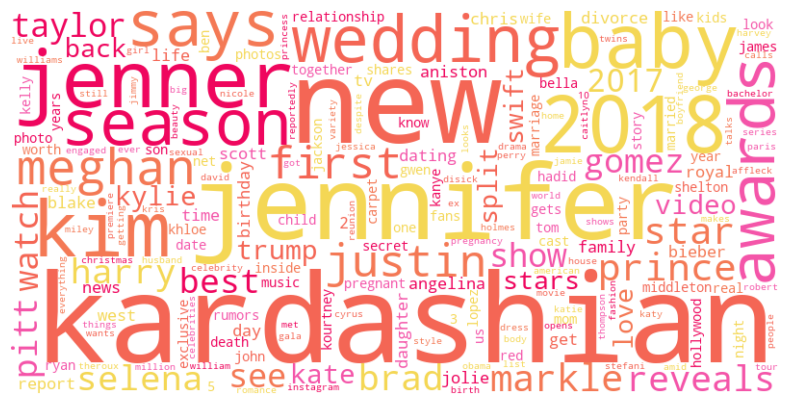

In [182]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import pandas as pd
import random

def get_words():
    # Tokenize the titles into words
    titles = ' '.join(df['title'])  # Combine all titles into a single string
    words = nltk.word_tokenize(titles.lower())  # Tokenize and convert to lowercase

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

    # Count the frequency of each word
    word_freq = Counter(filtered_words)

    # Sort the words based on frequency
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_words

# Display the top 10 most frequent words
sorted_words=get_words()
top_words = sorted_words[:10]
for word, freq in top_words:
    print(f'{word}: {freq}')

def orange_pink_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    colors = ['#EF065E', '#F46655', '#F4D755', '#F455A9', '#F47955']  # Define your desired colors here
    return random.choice(colors)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',color_func=orange_pink_color).generate_from_frequencies(dict(sorted_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
